In [1]:
# use "pip install [PACKAGE_NAME]" to get any required packages you don't have

import gymnasium as gym
import numpy as np
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear
import tensorflow as tf
from datetime import datetime

In [2]:
# options: original, plus_velocity, human
reward_type = "original"
episodes = 40

# checks that GPU is being used
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
curr_time = datetime.now()
time_stamp = curr_time.timestamp()
date_time = datetime.fromtimestamp(time_stamp)

date = str(date_time)[0:10]
time = str(date_time)[11:19].replace(":", '-')

In [4]:
env = gym.make('MountainCar-v0', render_mode = "human")
#env.seed(134)
np.random.seed(458)

In [5]:
class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .95
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .995
        self.memory = deque(maxlen=100000)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(32, input_dim=self.state_space, activation=relu))
        model.add(Dense(32, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def save(self, name):
        self.model.save(name)

In [6]:
def get_reward(state, next_state, reward_type):
    if reward_type == "original":
        if next_state[0] >= 0.5:
            print("Car has reached the goal")
            return 10
        if next_state[0] > -0.4:
            return (1+next_state[0])**2
        return 0
    
    elif reward_type == "plus_velocity":
        if next_state[0] >= 0.5:
            print("Car has reached the goal")
            return 10
        # if the next action goes higher or has greater speed, reward
        if next_state[0] > state[0][0] or abs(next_state[1]) > abs(state[0][1]):
            return 1
        else: 
            return 0
    
    elif reward_type == "human":
        if next_state[0] >= 0.5:
            print("Car has reached the goal")
            return 10
        # if slowing down and going higher, reward
        if next_state[0] > state[0][0] and abs(next_state[1]) < abs(state[0][1]):
            return 1
        # if speeding up and going lower, reward
        if next_state[0] < state[0][0] and abs(next_state[1]) > abs(state[0][1]):
            return 1
        else:
            return 0

    else:
        return 0

In [7]:
def train_dqn(episode):

    loss = []
    step_count = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in range(episode):
        state = env.reset()[0] # added [0]
        state = np.reshape(state, (1, 2))
        score = 0
        max_steps = 500 # changed from 1000
        for i in range(max_steps):
            action = agent.act(state)
            env.render()
            next_state, reward, done, _ = env.step(action)[0:4] # added [0:4]
            reward = get_reward(state, next_state, reward_type)
            score += reward
            next_state = np.reshape(next_state, (1, 2))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                print("episode: {}/{} (reached goal), score: {}".format(e, episode, score))
                if e == max(range(episode)):
                    agent.save("MC_v3_models/model_{}_{}_{}_{}.h5".format(reward_type, date, time, e))
                break
        if not done:
            print("episode: {}/{} (did not reach goal), score: {}".format(e, episode, score))
        loss.append(score)
        step_count.append(i)
    return loss, step_count


In [8]:
def random_policy(episode, step):

    for i_episode in range(episode):
        env.reset()
        for t in range(step):
            env.render()
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                break
            print("Starting next episode")

In [ ]:
print(env.observation_space)
print(env.action_space)

loss, step_count = train_dqn(episodes)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(3)
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


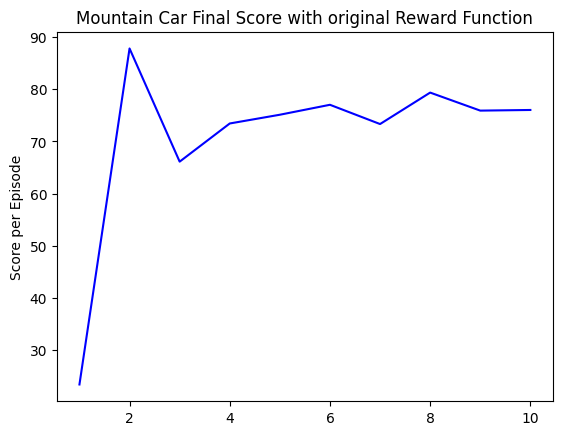

In [20]:
colors = {"original" : "blue", "plus_velocity" : "green", "human" : "red"}

plt.plot([i+1 for i in range(episodes)], loss, color = colors[reward_type])
plt.ylabel('Score per Episode')
plt.xlabel('episodes')
plt.title("Mountain Car Final Score with {} Reward Function".format(reward_type))
plt.savefig("./MC_v3_plots/loss_{}_{}_{}.png".format(reward_type, date, time))
plt.show()

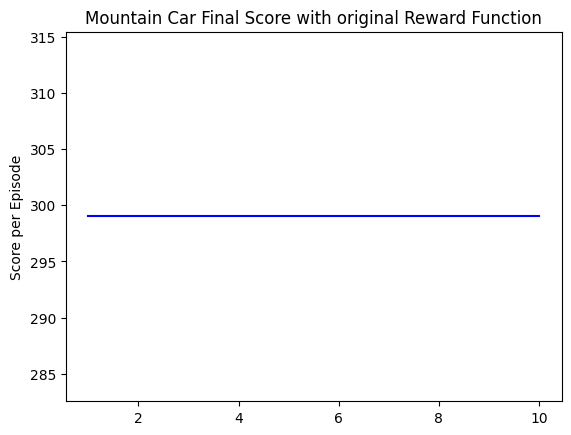

In [21]:
plt.plot([i+1 for i in range(episodes)], step_count, color = colors[reward_type])
plt.ylabel('Steps per Episode')
plt.xlabel('episodes')
plt.title("Mountain Car Final Score with {} Reward Function".format(reward_type))
plt.savefig("MC_v3_plots/step_{}_{}_{}.png".format(reward_type, date, time))
plt.show()